## 1. 决策树的构造

> 优点：计算复杂度不高，输出结果易于理解，对中间值的缺失不敏感，可以处理不想管特征数据

> 缺点：可能会产生过度匹配问题

> 适用数据类型：数字型或标称型

这里将采用[ID3](https://en.wikipedia.org/wiki/ID3_algorithm)算法

### 1.1 信息增益

划分数据集的最大原则是：将无序的数据变得更加有序。

组织杂乱无章数据的一种方法就是使用信心论度量信息，在划分数据集之前之后信息发生的变化称为**信息增益**，获得信息增益最高的特征就是最好的选择。

信息熵定义为信息的期望值：

$l\left( x_{i}\right) =-\log _{2}p\left( x_{i}\right)$

$H=-\sum ^{n}_{i=1}p\left( x_{i}\right) \log _{2}p\left( x_{i}\right)$

In [1]:
from math import log

In [2]:
# 计算熵
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for fectVec in dataSet:
        currentLabel = fectVec[-1]
        labelCounts[currentLabel] = labelCounts.get(currentLabel, 0) + 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

In [93]:
# 构造一个测试样本
def createDataSet():
    dataSet = [[1, 1, 'yes'],
              [1, 1, 'yes'],
              [1, 0, 'no'],
              [0, 1, 'no'],
              [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']
    return dataSet, labels

In [106]:
myDat, labels = createDataSet()
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [95]:
calcShannonEnt(myDat)

0.9709505944546686

> 另外一个度量集合无序程度的方法是“基尼不纯度”，这里不考虑。

### 1.2 划分数据集

In [36]:
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [37]:
splitDataSet(myDat, 0, 0)

[[1, 'no'], [1, 'no']]

选择最好的数据集划分方式

In [38]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy
        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

### 1.3 递归构建决策树

有的时候数据集已经处理了所有属性，但是类标签依旧不是唯一的，这种情况通常采用**多数表决**的方式。

In [92]:
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        classCount[vote] = classCount.get(vote, 0) + 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

In [90]:
# 创建树
def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]
    # 终止条件
    if classList.count(classList[0]) == len(classList): # 类别相同
        return classList[0]
    if len(dataSet[0]) == 1: # 遍历完所有特征，选择出现次数最多的
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel: {}}
    del labels[bestFeat]
    featValue = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValue)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree

In [107]:
myTree = createTree(myDat, labels)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## 2. 绘制决策树

这里借助graphviz包

In [18]:
from graphviz import Digraph

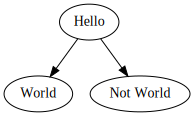

In [27]:
dot = Digraph()
dot.edge('Hello', 'World')
dot.edge('Hello', 'Not World')
dot

In [124]:
dot = Digraph()
def plotRoot(root, child, id=''):
    id += str(root)
    dot.node(id, str(root))
    if type(child).__name__ == 'dict':
        for key in child:
            dot.node(id+str(key), str(key))
            dot.edge(id, id+str(key))
            plotRoot(key, child[key], id)
    else:
        dot.node(id+str(child), str(child))
        dot.edge(id, id+str(child))
                
def plotTree(tree):
    for key in tree:
        plotRoot(key, tree[key])
        

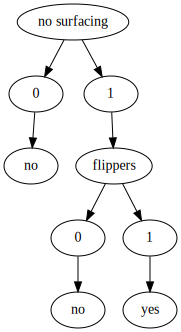

In [125]:
plotTree(myTree)
dot

## 3.测试和存储分类器

### 3.1 测试算法：使用决策树执行分类

In [32]:
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

In [33]:
myDat, labels = createDataSet()
myTree = createTree(myDat, labels[:])
classify(myTree, labels, [1, 0])

'no'

### 3.2 决策树的存储

决策树的生成结果可以存储在硬盘上，而不用每次都要重新生成。

In [108]:
def storeTree(inputTree, filename):
    import pickle
    f = open(filename, 'wb')
    pickle.dump(inputTree, f)
    f.close()

def grabTree(filename):
    import pickle
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [109]:
storeTree(myTree, 'classifierStorage.txt')
myTree = grabTree('classifierStorage.txt')
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## 4.示例：使用决策树预测隐形眼睛类型

In [110]:
with open('lenses.txt') as f:
    lenses = [item.strip().split('\t') for item in f.readlines()]
    lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
    lensesTree = createTree(lenses, lensesLabels)

In [111]:
lensesTree

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'young': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'no lenses'}}

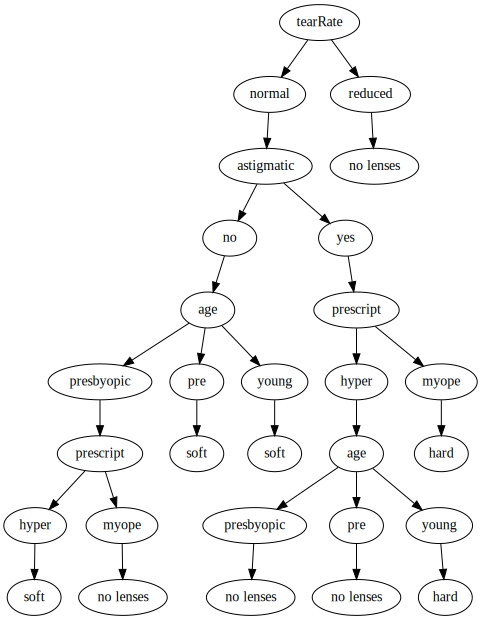

In [127]:
# plot
dot = Digraph()
plotTree(lensesTree)
dot

有的时候决策树会出现过度匹配的情况，这个时候就需要剪枝，后面还会学习另一种构造算法CART。

> ID3算法无法直接处理数值型数据，k-近邻算法和决策树都是明确的分类，下面会接触一种不能完全确定数据应该分为某个类，只是给出具体的概率。